# Explainability – zrozumienie decyzji modelu

Celem tego etapu jest wyjaśnienie, w jaki sposób model podejmuje decyzje
o zaklasyfikowaniu klienta jako wypłacalnego lub niewypłacalnego.
W środowisku bankowym interpretowalność modelu jest kluczowa – zarówno
ze względów regulacyjnych, jak i biznesowych.


## 1) Importy + wczytanie danych

In [1]:
import numpy as np
import pandas as pd

import shap
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from xgboost import XGBClassifier


In [2]:
train = pd.read_parquet("train.parquet")
test = pd.read_parquet("test.parquet")

train.shape, test.shape


((20000, 11), (5000, 11))

## 2) Cleaning + Feature Engineering (ta sama logika co wcześniej)

In [3]:
def clean_and_engineer(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # 1) proste czyszczenie (zgodnie z tym co miałeś wcześniej)
    df.loc[df["Income"] < 0, "Income"] = np.nan
    df.loc[df["LoanAmount"] < 0, "LoanAmount"] = np.nan

    # 2) nowe cechy (Twoje 3 „pro” feature’y)
    df["Income_per_Dependent"] = df["Income"] / (df["NumDependents"] + 1)
    df["Loan_to_Income"] = df["LoanAmount"] / (df["Income"] + 1e-6)
    df["Employment_Ratio"] = df["EmploymentYears"] / (df["Age"] + 1e-6)

    return df


In [4]:
df_train = clean_and_engineer(train)
df_test = clean_and_engineer(test)


## 3) Zmienne + pipeline XGBoost (taki sam jak baseline, tylko „tu i teraz”)

In [5]:
target = "Default"

num_features = [
    "Age","Income","CreditScore","LoanAmount",
    "EmploymentYears","NumDependents","DebtToIncome","EducationLevel",
    "Income_per_Dependent","Loan_to_Income","Employment_Ratio"
]
cat_features = ["FavoriteColor","Hobby"]

X_train = df_train.drop(columns=[target]).copy()
y_train = df_train[target].copy()

X_test = df_test.drop(columns=[target]).copy()
y_test = df_test[target].copy()


In [6]:
numeric_transformer_xgb = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
])

categorical_transformer_xgb = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore")),
])

preprocessor_xgb = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_xgb, num_features),
        ("cat", categorical_transformer_xgb, cat_features),
    ]
)

pipeline_xgb = Pipeline(steps=[
    ("preprocessor", preprocessor_xgb),
    ("model", XGBClassifier(
        n_estimators=300,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        random_state=42
    ))
])


In [7]:
pipeline_xgb.fit(X_train, y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers co

## 4) Przygotowanie danych „po preprocessingu” + nazwy cech

In [8]:
preprocessor = pipeline_xgb.named_steps["preprocessor"]
model = pipeline_xgb.named_steps["model"]

X_train_trans = preprocessor.transform(X_train)
X_test_trans = preprocessor.transform(X_test)

feature_names = preprocessor.get_feature_names_out()
len(feature_names)


19

## 5. Model Explainability – SHAP

Aby zrozumieć, **dlaczego** model podejmuje konkretne decyzje, wykorzystujemy bibliotekę SHAP (SHapley Additive exPlanations).

SHAP pozwala:
- określić, które cechy mają największy wpływ na predykcje modelu (globalnie),
- wyjaśnić pojedynczą decyzję modelu dla konkretnego klienta,
- zbudować zaufanie do modelu w kontekście biznesowym (explainable AI).

W analizie używamy reprezentatywnej próbki danych treningowych (n=2000), już po preprocessingu – dokładnie w takiej postaci, w jakiej widzi je model.


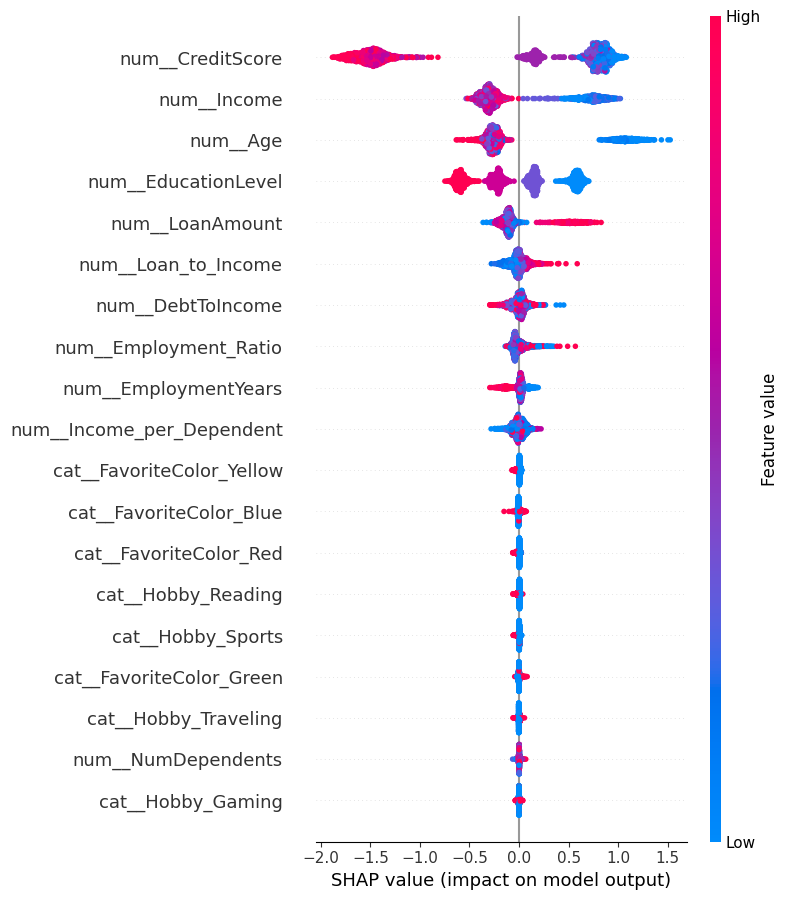

In [11]:
rng = np.random.RandomState(42)
idx = rng.choice(
    X_train_trans.shape[0],
    size=min(2000, X_train_trans.shape[0]),
    replace=False
)

X_sample = X_train_trans[idx]

# jeśli sparse → zamień na dense tylko dla próbki
if hasattr(X_sample, "toarray"):
    X_sample = X_sample.toarray()

# upewnij się, że to czyste floaty
X_sample = np.asarray(X_sample, dtype=float)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_sample)

sv = shap_values[1] if isinstance(shap_values, list) else shap_values
feature_names_fixed = [str(x) for x in feature_names]

import matplotlib.pyplot as plt

shap.summary_plot(
    sv,
    X_sample,
    feature_names=feature_names_fixed,
    show=False
)

plt.tight_layout()
plt.savefig("docs/img/shap_summary.png", dpi=150, bbox_inches="tight")
plt.show()




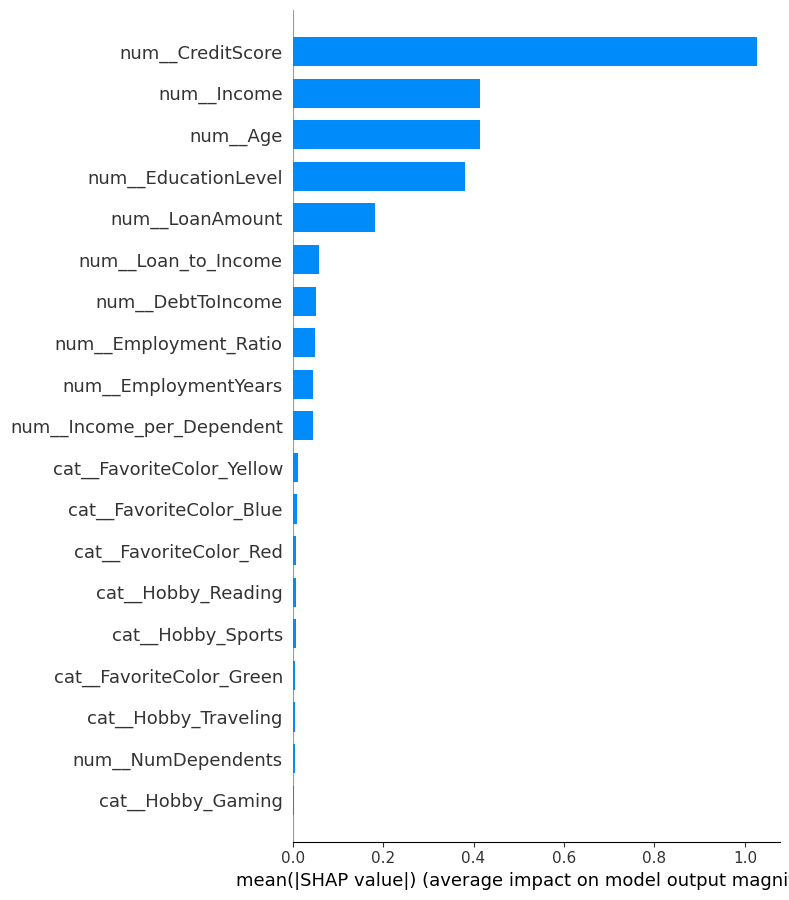

In [12]:
import matplotlib.pyplot as plt

shap.summary_plot(
    sv,
    X_sample,
    feature_names=feature_names_fixed,
    plot_type="bar",
    show=False
)

plt.tight_layout()
plt.savefig("docs/img/shap_global_bar.png", dpi=150, bbox_inches="tight")
plt.show()


Powyższy wykres pokazuje globalną ważność cech – średni bezwzględny wpływ każdej zmiennej na decyzje modelu.
Pozwala to szybko zidentyfikować kluczowe czynniki ryzyka odejścia klienta.


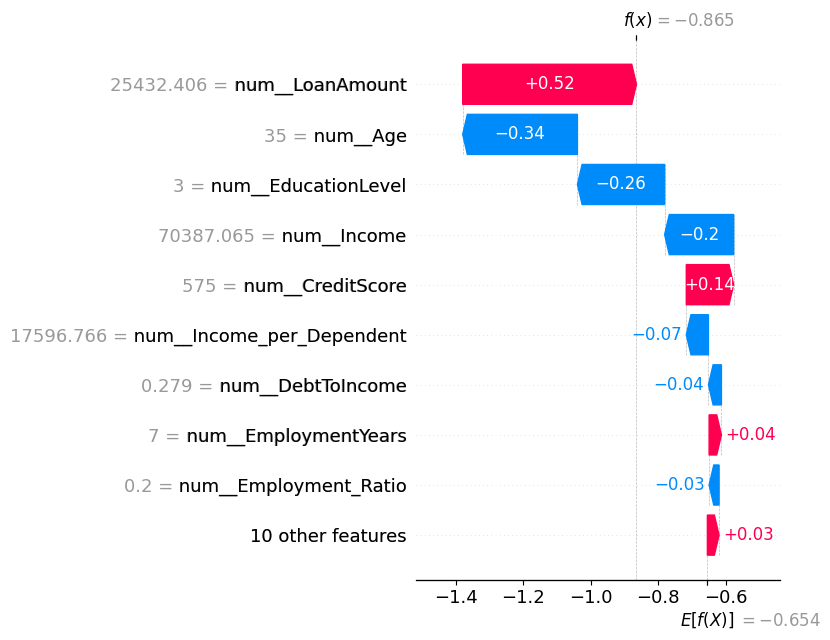

In [13]:
i = 0  # pierwszy klient z próbki

shap.waterfall_plot(
    shap.Explanation(
        values=sv[i],
        base_values=explainer.expected_value[1]
        if isinstance(explainer.expected_value, (list, np.ndarray))
        else explainer.expected_value,
        data=X_sample[i],
        feature_names=feature_names_fixed
    ),
    show=False
)

plt.tight_layout()
plt.savefig("docs/img/shap_waterfall_example.png", dpi=150, bbox_inches="tight")
plt.show()



Ten wykres pokazuje, jak poszczególne cechy wpływają na decyzję modelu
dla konkretnego klienta – które zwiększają, a które zmniejszają
prawdopodobieństwo odejścia.

- Cechy po prawej stronie (wartości dodatnie) **zwiększają** ryzyko churnu.  
- Cechy po lewej stronie (wartości ujemne) **zmniejszają** ryzyko churnu.  
- Kolor czerwony oznacza wysoką wartość danej cechy u klienta,  
  a niebieski – niską wartość.

W ten sposób można zobaczyć nie tylko *co* wpłynęło na decyzję modelu,
ale także *w jakim kierunku* dana cecha zadziałała.

Taki poziom interpretowalności jest kluczowy w zastosowaniach biznesowych,
np. w bankowości, gdzie decyzje modelu muszą być możliwe do wyjaśnienia
i uzasadnienia.
